# Import libraries

In [2]:
import pyodbc
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from IPython.display import display

# Database connection details

In [3]:
DB = {'servername': 'RAMCO\SQLEXPRESS',
      'database': 'UnitedoutdoorsDWH'}

export_conn = pyodbc.connect('DRIVER={SQL Server};SERVER=' + DB['servername'] + ';DATABASE=' + DB['database'] + ';Trusted_Connection=yes')

<>:1: SyntaxWarning: invalid escape sequence '\S'
<>:1: SyntaxWarning: invalid escape sequence '\S'
C:\Users\ramco\AppData\Local\Temp\ipykernel_13476\3671513759.py:1: SyntaxWarning: invalid escape sequence '\S'
  DB = {'servername': 'RAMCO\SQLEXPRESS',


# Fetch relevant data from the database

In [4]:
orders_df = pd.read_sql_query("SELECT OrderKey, OrderID FROM dbo.Sales", export_conn)
order_details_df = pd.read_sql_query("SELECT OrderKey, ProductKey, EmployeeKey, Quantity, UnitPrice FROM dbo.Sales", export_conn)
display(orders_df)
display(order_details_df)

C:\Users\ramco\AppData\Local\Temp\ipykernel_13476\4285783256.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  orders_df = pd.read_sql_query("SELECT OrderKey, OrderID FROM dbo.Sales", export_conn)
C:\Users\ramco\AppData\Local\Temp\ipykernel_13476\4285783256.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  order_details_df = pd.read_sql_query("SELECT OrderKey, ProductKey, EmployeeKey, Quantity, UnitPrice FROM dbo.Sales", export_conn)


,OrderKey,OrderID
0,1,10248
1,2,10248
2,3,10248
3,4,10249
4,5,10249
...,...,...
124570,124571,2654
124571,124572,2654
124572,124573,2003
124573,124574,2003


,OrderKey,ProductKey,EmployeeKey,Quantity,UnitPrice
0,1,525,97.0,12,14.0
1,2,556,97.0,10,9.8
2,3,586,97.0,5,34.8
3,4,528,98.0,9,18.6
4,5,565,98.0,40,42.4
...,...,...,...,...,...
124570,124571,507,21.0,3,14.0
124571,124572,508,21.0,8,9.0
124572,124573,508,68.0,12,9.0
124573,124574,510,68.0,12,7.0


# Data Preperation

In [5]:
# Calculate the order value for each order detail line
order_details_df['OrderValue'] = order_details_df['UnitPrice'] * order_details_df['Quantity']

# Merge orders and order details to calculate total order value per order
merged_orders_df = pd.merge(orders_df, order_details_df, on='OrderKey', how='left')

# Calculate the total order value per order and product
total_order_value_per_product = merged_orders_df.groupby('ProductKey')['OrderValue'].sum().reset_index()

# Calculate the number of orders per product
order_counts_per_product = merged_orders_df.groupby('ProductKey')['OrderKey'].nunique().reset_index()
order_counts_per_product.columns = ['ProductKey', 'OrderCount']

# Merge the total order value with the order counts
product_order_values = pd.merge(total_order_value_per_product, order_counts_per_product, on='ProductKey')

# Calculate the average order value per product
product_order_values['AverageOrderValue'] = product_order_values['OrderValue'] / product_order_values['OrderCount']

# Display the average order value per product key
display(product_order_values[['ProductKey', 'AverageOrderValue']])

# Print the average order value per product key
print(product_order_values[['ProductKey', 'AverageOrderValue']])


,ProductKey,AverageOrderValue
0,212,51.529251
1,213,53.899139
2,214,32.704787
3,215,11.659091
4,216,53.954437
...,...,...
348,587,300.000000
349,588,197.384615
350,589,188.055435
351,590,430.615385


     ProductKey  AverageOrderValue
0           212          51.529251
1           213          53.899139
2           214          32.704787
3           215          11.659091
4           216          53.954437
..          ...                ...
348         587         300.000000
349         588         197.384615
350         589         188.055435
351         590         430.615385
352         591         254.868421

[353 rows x 2 columns]


# Visualize the clusters

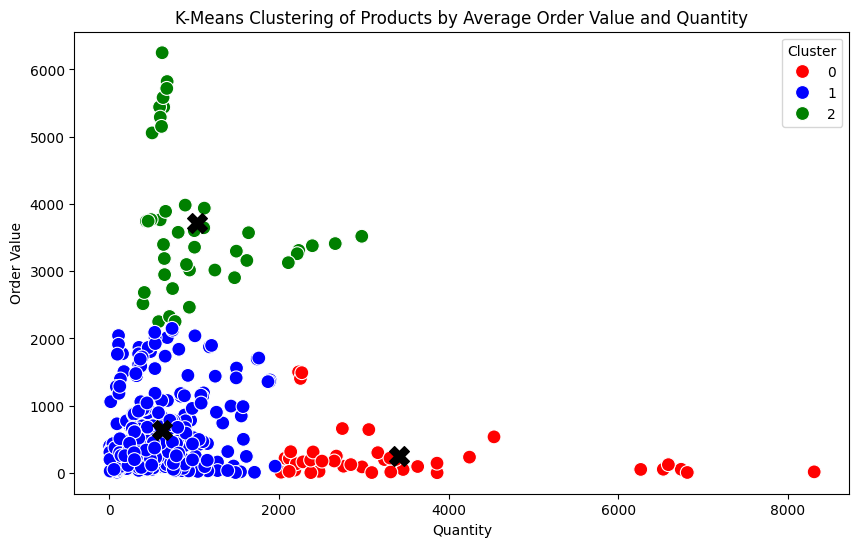

,ProductKey,AverageOrderValue,Quantity,Cluster
0,212,51.529251,6266,0
1,213,53.899139,6532,0
2,214,32.704787,1107,1
3,215,11.659091,90,1
4,216,53.954437,6743,0
...,...,...,...,...
348,587,300.000000,293,1
349,588,197.384615,297,1
350,589,188.055435,1155,1
351,590,430.615385,981,1


In [12]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(product_order_values[['AverageOrderValue', 'Quantity']])

kmeans = KMeans(n_clusters=3, random_state=42)
product_order_values['Cluster'] = kmeans.fit_predict(scaled_data)

cluster_colors = {0: 'red', 1: 'blue', 2: 'green'}

plt.figure(figsize=(10, 6))
sns.scatterplot(data=product_order_values, x='Quantity', y='AverageOrderValue', hue='Cluster', palette=cluster_colors, s=100)

for cluster in product_order_values['Cluster'].unique():
    cluster_data = product_order_values[product_order_values['Cluster'] == cluster]
    avg_quantity = cluster_data['Quantity'].mean()
    avg_order_value = cluster_data['AverageOrderValue'].mean()
    plt.scatter(avg_quantity, avg_order_value, color='black', edgecolor='black', s=200, marker='X')

plt.title('K-Means Clustering of Products by Average Order Value and Quantity')
plt.xlabel('Quantity')
plt.ylabel('Order Value')
plt.legend(title='Cluster')
plt.show()

display(product_order_values[['ProductKey', 'AverageOrderValue', 'Quantity', 'Cluster']])